In [1]:
!nvidia-smi


Tue May  6 20:15:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   31C    P0              23W / 250W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
!ps aux | grep python

root       11612  0.0  0.0 2511900 75624 ?       Sl   mar06  42:03 /usr/bin/python3 /usr/lpp/mmfs/bin/mmsysmon.py
mtorgema 3678885  1.4  0.0 568232 119624 pts/0   SNl+ 14:15   0:21 /home/mtorgema/.conda/envs/vidtok/bin/python /home/mtorgema/.conda/envs/vidtok/bin/jupyter-lab --no-browser --port=8888 --ip=10.91.27.50
mtorgema 3679029  1.7  0.6 46749672 2653476 ?    SNsl 14:16   0:26 /home/mtorgema/.conda/envs/vidtok/bin/python -m ipykernel_launcher -f /home/mtorgema/.local/share/jupyter/runtime/kernel-d1c36457-8286-46f4-859d-9722f19360c3.json
mtorgema 3683627  0.0  0.0   7276  3536 pts/1    SNs+ 14:41   0:00 /bin/bash -c ps aux | grep python
mtorgema 3683630  0.0  0.0   6416  2244 pts/1    SN+  14:41   0:00 grep python


In [4]:
!pip install imageio[ffmpeg]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 41.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


[vidtok.modules.losses][GeneralLPIPSWithDiscriminator] running with dims=3. This means that for perceptual loss 
calculation, the LPIPS loss will be applied to each frame independently.

[vidtok.modules.lpips][get_ckpt_path] Using existing path for vgg_lpips model: checkpoints/lpips/vgg.pth

[vidtok.modules.lpips][LPIPS] loaded pretrained LPIPS loss from checkpoints/lpips/vgg.pth

[vidtok.models.autoencoder][AutoencodingEngine] Use ckpt_path: 
/work/com-304/IAY_neurons_u2/tokenizer/VidTok/checkpoints/vidtok_kl_causal_288_8chn.ckpt

[vidtok.models.autoencoder][AutoencodingEngine] Restored from 
/work/com-304/IAY_neurons_u2/tokenizer/VidTok/checkpoints/vidtok_kl_causal_288_8chn.ckpt with 0 missing and 0 
unexpected keys

Input tensor shape: torch.Size([1, 3, 17, 720, 1280])
Chunk 0:8 — raw tokens shape: torch.Size([1, 8, 4, 90, 160])

=== Tokens (indices) pour chunk 0, frame 0 ===
[[6 6 2 ... 6 6 7]
 [4 2 6 ... 5 6 6]
 [2 2 5 ... 6 1 7]
 ...
 [1 4 4 ... 6 2 7]
 [2 4 2 ... 6 6 6]
 [2 5 6 ... 6 6 7]]


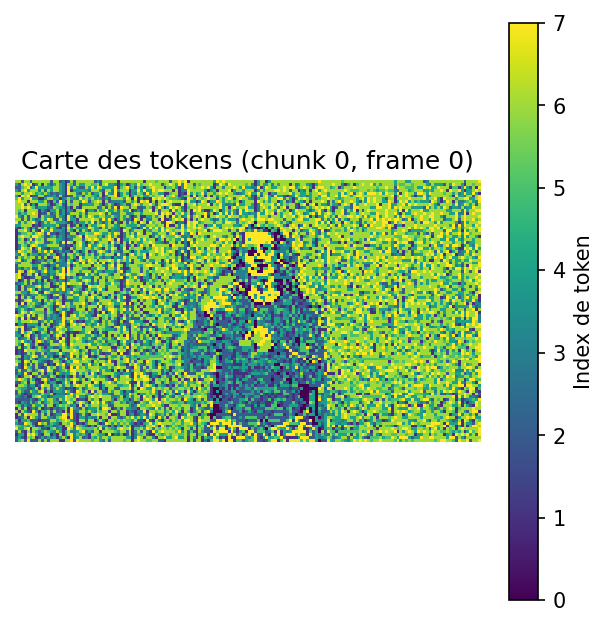

Chunk 8:16 — raw tokens shape: torch.Size([1, 8, 4, 90, 160])
Chunk 16:17 — raw tokens shape: torch.Size([1, 8, 1, 90, 160])
⚠️ Reconstruit 15 frames sur 17 originales — on s'aligne sur 15.
Vidéos sauvegardées dans : /work/com-304/IAY_neurons_u2/tokenizer/VidTok/recon_video (15 frames)
PSNR moyen : 22.98 dB — SSIM moyen : 0.923


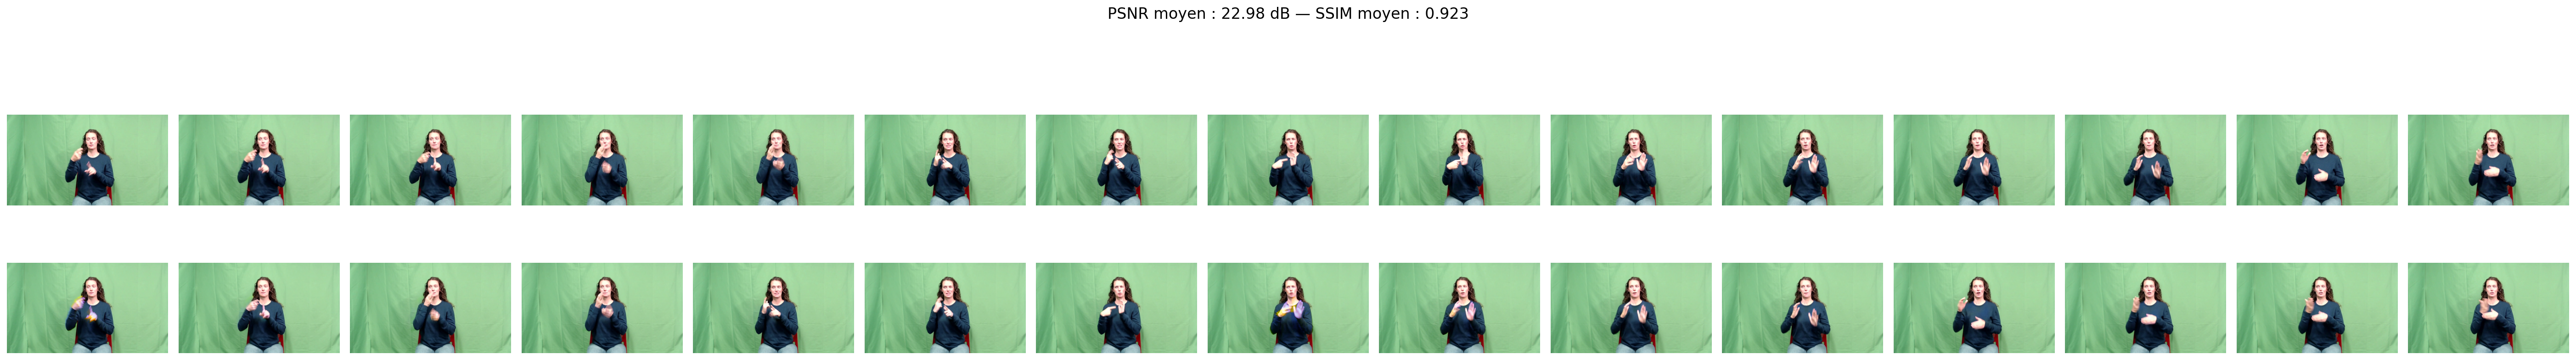

Plot comparatif sauvegardé ici : /work/com-304/IAY_neurons_u2/tokenizer/VidTok/recon_video/comparison_plot.png


In [2]:
#!/usr/bin/env python3
import os
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scripts.inference_evaluate import load_model_from_config

def to_numpy(x: torch.Tensor):
    if x.dim() == 5:
        x = x[0]  # (3, T, H, W)
    img = ((x.clamp(-1,1) + 1) * 127.5).permute(1,2,3,0)
    return img.cpu().numpy().astype('uint8')

def main():
    # ---- 1. Chemins et paramètres ----
    frame_dir  = "/work/com-304/IAY_neurons_u2/tokenizer/_2FBDaOPYig_1-3-rgb_front/rgb_keyframes"
    output_dir = "/work/com-304/IAY_neurons_u2/tokenizer/VidTok/recon_video"
    os.makedirs(output_dir, exist_ok=True)

    cfg_path  = "/work/com-304/IAY_neurons_u2/tokenizer/VidTok/configs/vidtok_kl_causal_288_8chn.yaml"
    ckpt_path = "/work/com-304/IAY_neurons_u2/tokenizer/VidTok/checkpoints/vidtok_kl_causal_288_8chn.ckpt"

    # ---- 2. Charger les images originales ----
    frame_files = sorted(
        f for f in os.listdir(frame_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    )[:17]
    orig_images = [Image.open(os.path.join(frame_dir, f)).convert('RGB') for f in frame_files]

    # ---- 3. Charger le modèle en FP16 sur GPU ----
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    model = load_model_from_config(cfg_path, ckpt_path)
    model = model.to(device).eval().half()

    # ---- 4. Préparer le tenseur [1,3,T,H,W] ----
    tensor_list = []
    for img in orig_images:
        arr = np.array(img)                   # (H, W, 3)
        t   = torch.from_numpy(arr).permute(2,0,1).float()  # (3, H, W)
        t   = (t / 127.5) - 1                 # normalisation [-1,1]
        tensor_list.append(t)
    tensors = torch.stack(tensor_list, dim=1).unsqueeze(0).to(device).half()
    T_orig = tensors.shape[2]
    print(f"Input tensor shape: {tensors.shape}")  # (1,3,T,H,W)

    # ---- 5. Reconstruction en chunks + extraction des tokens ----
    chunk_size   = 8
    recon_chunks = []
    plotted = False  # flag pour ne tracer que la première fois
    for start in range(0, T_orig, chunk_size):
        end = min(start + chunk_size, T_orig)
        sub = tensors[:, :, start:end]  # (1,3,<=chunk_size,H,W)
        with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
            tokens, recon_sub, _ = model(sub)

        # Afficher la shape brutes des tokens
        print(f"Chunk {start}:{end} — raw tokens shape: {tokens.shape}")

        # Conversion en indices (one-hot → argmax si nécessaire)
        if tokens.dim() == 5:
            token_indices = tokens.argmax(dim=1)  # (B, T', H', W')
        else:
            token_indices = tokens              # déjà (B, T', H', W')
        token_indices = token_indices.cpu().long()

        # Pour le premier chunk uniquement, afficher et tracer la carte de tokens de la première frame
        if not plotted:
            plotted = True
            idx_map = token_indices[0, 0].numpy()  # first batch, first time-step
            print("\n=== Tokens (indices) pour chunk 0, frame 0 ===")
            print(idx_map)

            plt.figure(figsize=(5,5))
            plt.title("Carte des tokens (chunk 0, frame 0)")
            plt.imshow(idx_map, interpolation='nearest')
            plt.colorbar(label='Index de token')
            plt.axis('off')
            plt.show()

        recon_chunks.append(recon_sub)

    recon_tensors = torch.cat(recon_chunks, dim=2)  # (1,3,T_recon,H,W)

    # ---- 6. Conversion en numpy (T,H,W,3) ----
    orig_np  = to_numpy(tensors)
    recon_np = to_numpy(recon_tensors)
    T_recon  = recon_np.shape[0]
    T        = min(T_orig, T_recon)
    if T_recon < T_orig:
        print(f"⚠️ Reconstruit {T_recon} frames sur {T_orig} originales — on s'aligne sur {T_recon}.")

    # ---- 7. Sauvegarde vidéo ----
    orig_vid  = os.path.join(output_dir, "original.mp4")
    recon_vid = os.path.join(output_dir, "reconstructed.mp4")

    writer_o = imageio.get_writer(orig_vid, mode='I', fps=30, codec='libx264', pixelformat='yuv420p')
    writer_r = imageio.get_writer(recon_vid, mode='I', fps=30, codec='libx264', pixelformat='yuv420p')
    for i in range(T):
        writer_o.append_data(orig_np[i])
        writer_r.append_data(recon_np[i])
    writer_o.close()
    writer_r.close()
    print(f"Vidéos sauvegardées dans : {output_dir} ({T} frames)")

    # ---- 8. Calcul des métriques PSNR & SSIM ----
    psnr_vals, ssim_vals = [], []
    for i in range(T):
        o, r = orig_np[i], recon_np[i]
        psnr_vals.append(peak_signal_noise_ratio(o, r, data_range=255))
        ssim_vals.append(structural_similarity(o, r, channel_axis=2, data_range=255))

    mean_psnr = np.mean(psnr_vals)
    mean_ssim = np.mean(ssim_vals)
    print(f"PSNR moyen : {mean_psnr:.2f} dB — SSIM moyen : {mean_ssim:.3f}")

    # ---- 9. Affichage & sauvegarde du plot comparatif ----
    plt.rcParams['figure.dpi'] = 150
    fig, axs = plt.subplots(2, T, figsize=(T*2.5, 6))
    for i in range(T):
        axs[0, i].imshow(orig_np[i]);  axs[0, i].axis('off')
        axs[1, i].imshow(recon_np[i]); axs[1, i].axis('off')
    fig.suptitle(f"PSNR moyen : {mean_psnr:.2f} dB — SSIM moyen : {mean_ssim:.3f}", y=1.02, fontsize=16)
    plt.tight_layout()
    plot_path = os.path.join(output_dir, "comparison_plot.png")
    fig.savefig(plot_path, bbox_inches="tight")
    plt.show()
    print(f"Plot comparatif sauvegardé ici : {plot_path}")

if __name__ == "__main__":
    main()
